# Prior Inspection
This notebook provides observation information and plots for identifying RFI contaminated data.

In [1]:
import os
import sys
import h5py
import yaml
import numpy as np
from astropy.time import Time
import astropy.units as u
from ipywidgets import interact

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.viridis  
cmap.set_bad(color='red')

from IPython.display import Image

# read yaml file
with open("../../input/config.yaml", "r") as file:
    conf = yaml.safe_load(file)
    
sys.path.append(os.path.join(os.curdir, "../../"))

from vlapy import vladata, inspect

## Obervation Information 
The data below is the output of CASA's listobs task and can be used to fill in the yaml file "obs.yaml", which contains all the parameters for the pipeline.

In [2]:
obs = conf["obs list"][8]
root = os.path.join(conf["root"], f"{obs}")
name = obs.split(".")[0]

ms = os.path.join(root, f"{obs}_hanning.ms")
vladata.listobs(ms)

BeginTime
58738.261828703704 

EndTime
58738.405810185184 

IntegrationTime
12440.0 

field_0
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 0.426245723}, 'm1': {'unit': 'rad', 'value': 0.5787469766000002}, 'refer': 'J2000', 'type': 'direction'}
name :  3C48


field_1
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -0.8285775652795861}, 'm1': {'unit': 'rad', 'value': 0.0720864154}, 'refer': 'J2000', 'type': 'direction'}
name :  J2050+0407


field_10
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -0.39795615887958685}, 'm1': {'unit': 'rad', 'value': 0.032775828900000005}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J2228+0152


field_11
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -0.3830975891795866}, 'm1': {'unit': 'rad', 'value': 0.0036768270000000006}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J2232+0012


field_12
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -0.3632771938795864}, 'm1': {'unit': 'rad', 'value'

### Array Layout

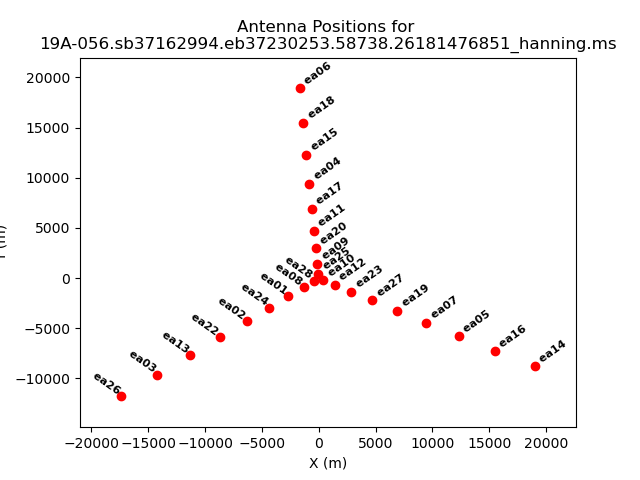

In [3]:
Image(filename=root + "/plots/obsplots/antlayout.png")

### Plot Elevation vs. Time
Observations low in elevation might see more RFI. The plot is colorised by field. Each target field is in between two phase calibrators.

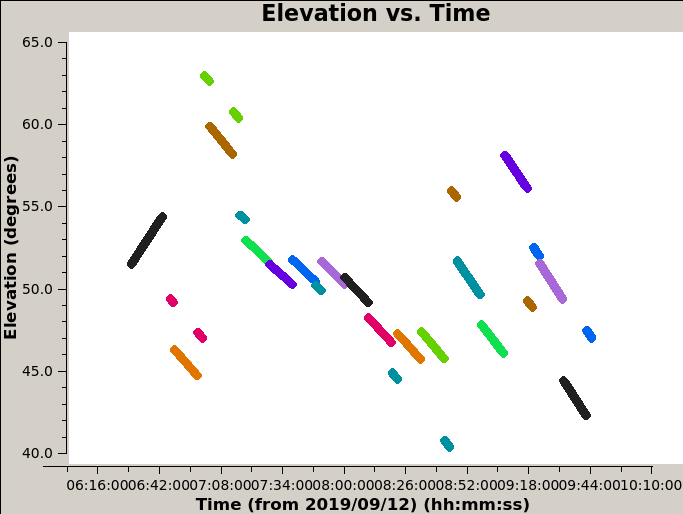

In [4]:
Image(filename=root + "/plots/obsplots/elevation_vs_time.png")

## VLA Deterministic Flags and Manual Flags
These include antennas not on source, shadowed antennas, scans with non-relevant intents, autocorrelations, edge channels of spectral windows, edge channels of the baseband, clipping absolute zero values produced by the correlator and the first few integrations of a scan (quacking). Manual flags are also applied for data known to be bad (RFI, obs reports). Below is a summary of the flags before and after applying the deterministic flags. Use the flagging frequency to find a suitable reference antenna and specify it in the yaml file.

In [5]:
summary_before = np.load(root + "/output/detflag_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/detflag_summary_after.npy", allow_pickle='TRUE').item()

# print flagging summary
def print_summary(item):
    for subitem in summary_before[item]:
        print(f"{item} {subitem}")
        print(
            "Before: {:.4f}, After: {:.4f}".format(
                100.0 * summary_before[item][subitem]["flagged"] / summary_before[item][subitem]["total"],
                100.0 * summary_after[item][subitem]["flagged"] / summary_after[item][subitem]["total"],
            )
        )
        print("")
        
print("Flag occupancy (percent) before and after deterministic flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after deterministic flags:

field 3C48
Before: 15.1695, After: 21.2158

field J2050+0407
Before: 51.1381, After: 54.2905

field J2139+1423
Before: 18.7679, After: 24.0087

field J2212+0152
Before: 13.8943, After: 19.5043

field J2236+2828
Before: 17.4687, After: 22.7933

field J2250+1419
Before: 22.1128, After: 27.1378

field QSO J2054-0005
Before: 4.6414, After: 10.7936

field QSO J2132+1217
Before: 4.4095, After: 10.5766

field QSO J2201+0155
Before: 4.0987, After: 10.2859

field QSO J2215+2606
Before: 5.3315, After: 11.4391

field QSO J2216-0016
Before: 4.8188, After: 10.9596

field QSO J2219+0102
Before: 3.7834, After: 10.2803

field QSO J2228+0128
Before: 4.6412, After: 10.7934

field QSO J2228+0152
Before: 3.4468, After: 10.2780

field QSO J2229+1457
Before: 4.8185, After: 10.9593

field QSO J2232+0012
Before: 4.0332, After: 10.2791

field QSO J2232+2930
Before: 3.7809, After: 10.2805

field QSO J2236+0032
Before: 5.1063, After: 11.2285

field 

### Plot Online Flags
Plot flaggingreason vs. time. This shows which antennas are flagged due to focus errors, subreflector errors and antenna not on source. This plot can help identify suitable reference antennas.

In [6]:
if os.path.exists(root+"/plots/dataplots/flaggingreason_vs_time.png"):
    Image(filename=root+"/plots/dataplots/flaggingreason_vs_time.png")

### Plot Antenna Data Stream
If an antenna has missing data, it should not be used as a reference.

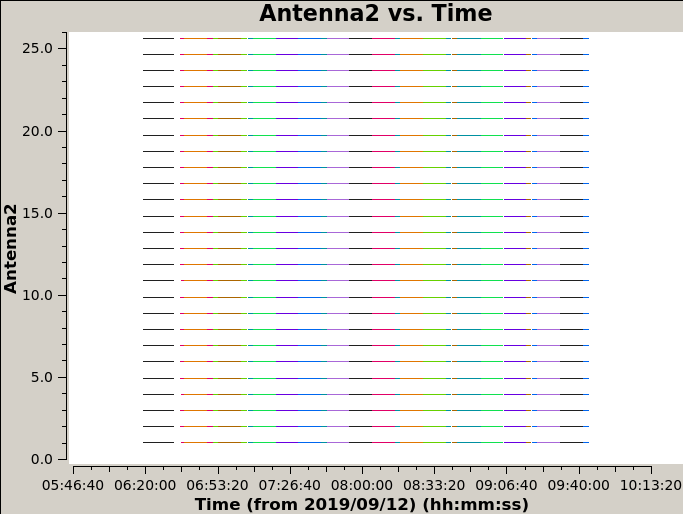

In [7]:
Image(filename=root + "/plots/obsplots/data_stream.png")

## Find Dead Antennas
Antennas that have low power should be flagged. This is also a good time to check for suitable reference antennas.

In [8]:
def plot_dead_ants(ant):
    plotfile = root + f"/plots/dataplots/find_dead_ants_amp_vs_freq_ant_{ant}.png"
    img = mpimg.imread(plotfile)
    plt.imshow(img)
    
interact(plot_dead_ants, ant=(1, 26))
    

interactive(children=(IntSlider(value=13, description='ant', max=26, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_dead_ants(ant)>

## RFI Inspection
The visibility amplitudes are first averaged across baselines and polarisation products. A modified Z-score is then computed across time as $Z_i = \frac{x_i - \mathrm{med}\{x_i\}_i}{\sigma_\mathrm{MAD}}$, 

where $\sigma_\mathrm{MAD} = \mathrm{med}\{\left|x_i - \mathrm{med}\{x_i\}_i\right|\}$ is the Median Absolute Deviation (MAD), and $x_i$ is the data (visibility amplitude) of the $i^\mathrm{th}$ integration.

The resulting Z-score is a spectrogram with dimensions of time and frequency. It can further be averaged across one of these dimensions to obtain a time series or a spectrum, which are useful for identifying broadband and persistent narrowband RFI respectively.

Use this to identify one clean channel per spectral window which will be used for the initial gain calibration.

#### Load Data

In [9]:
with h5py.File(root + f"/output/z_score_data.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

#### Plot

<IPython.core.display.Javascript object>


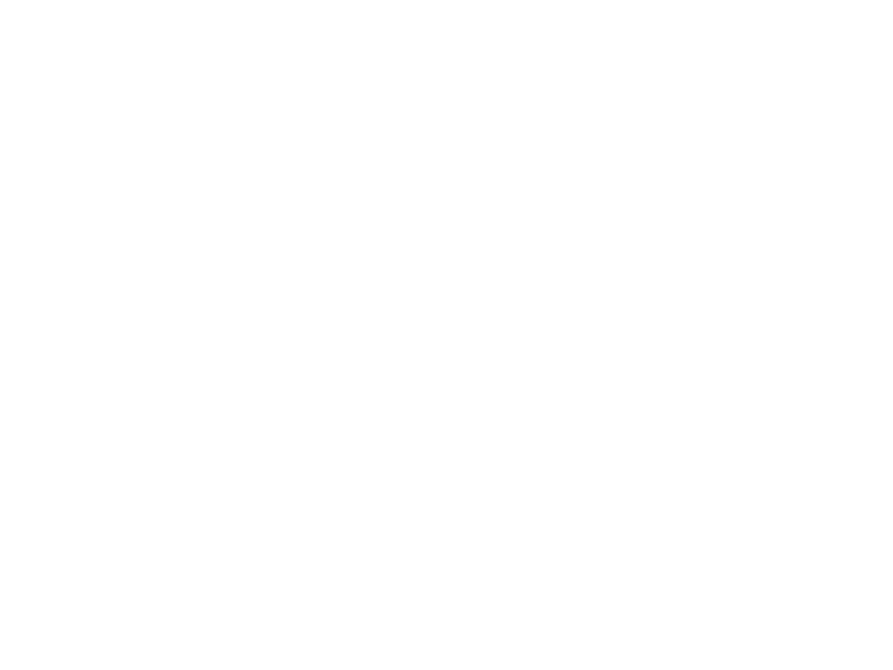

In [10]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1)
ax = inspect.plot_time_series(tisot, np.ma.median(z_score, axis=1), ax, plot_masked=True)
ax.set_ylabel("Averaged Z-Score (unitless)")
ax.set_xticks(tisot[::100])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


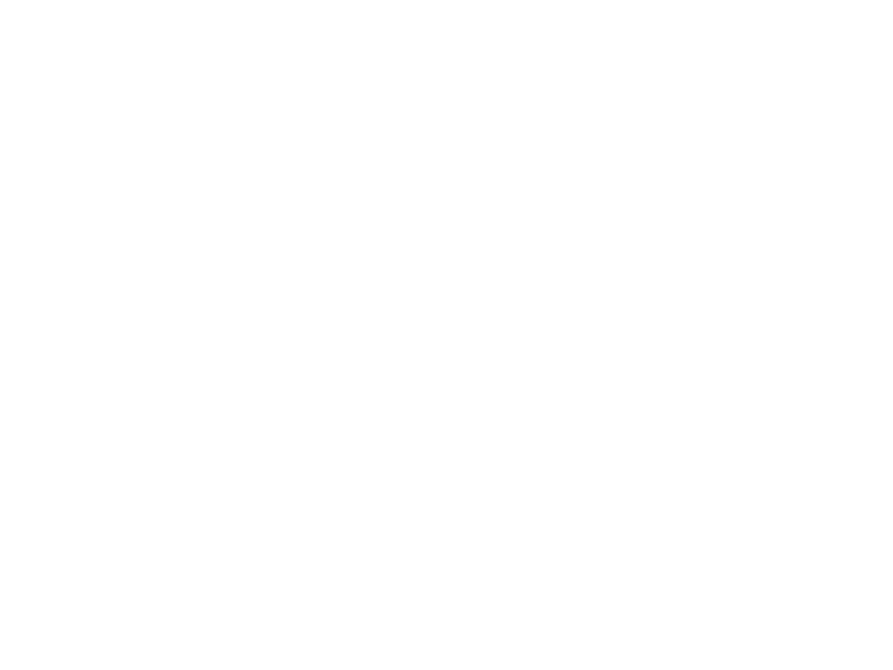

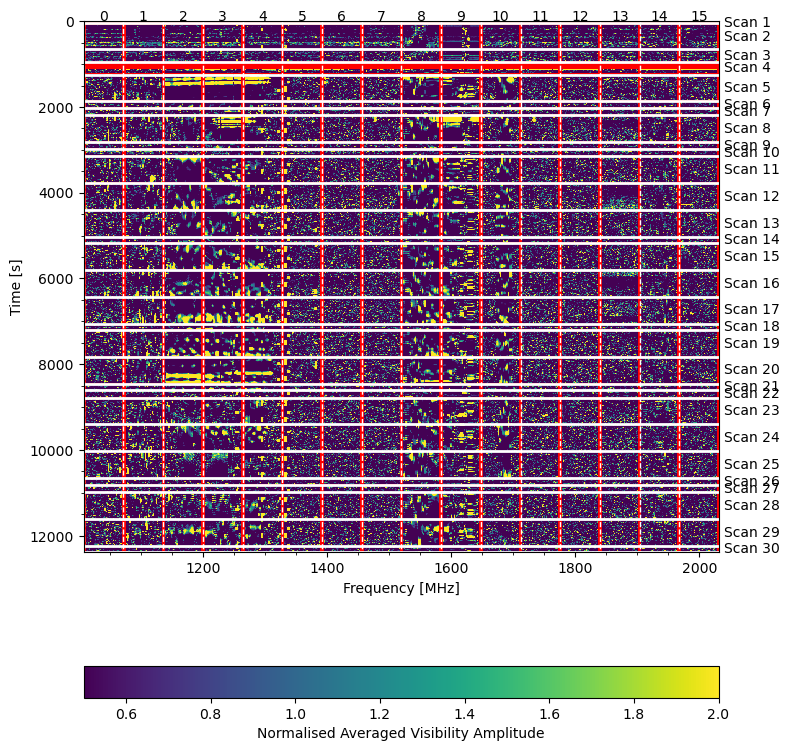

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=0.5, vmax=2, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", label="Normalised Averaged Visibility Amplitude")
plt.tight_layout()
plt.show()

In [12]:
def plot_wf_spw(i):
    inspect.plot_wf_spw(freq_array, z_score, i, 2, ntimes, cmap=cmap, plot_masked=True)
    
interact(plot_wf_spw, i=(0, 15))

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf_spw(i)>